In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# PREPROCESSING

In [1]:
img_size=256
BATCH_size=32
channels=3


In [36]:
import os
import cv2
import numpy as np
BASE_PATH = '/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/train'
unique_classes = os.listdir(BASE_PATH)
class_index = [unique_classes[0], unique_classes[1]] 

In [2]:
import tensorflow as tf
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/train", 
    shuffle=True,
    image_size=(img_size, img_size),
    batch_size=BATCH_size
)

Found 8116 files belonging to 2 classes.


In [3]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/val", 
    shuffle=True,
    image_size=(img_size, img_size),
    batch_size=BATCH_size
)

Found 900 files belonging to 2 classes.


In [4]:
class_names=dataset.class_names
class_names

['benign', 'malignant']

In [5]:
len(dataset)

254

In [6]:
254*32

8128

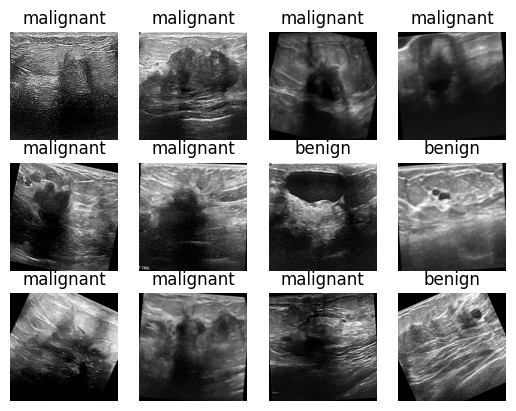

In [7]:
import matplotlib.pyplot as plt
for img_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(img_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
        #print(label_batch.numpy())

In [8]:
train_size=0.9
len(dataset)*train_size

228.6

In [9]:
train_ds= dataset.take(228)
len(train_ds)

228

In [10]:
val_ds=dataset.skip(228) 
len(val_ds)

26

**Shuffle the data into train and val**


In [11]:
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    # Calculate the number of training samples
    train_size = int(train_split * ds_size)

    # Calculate the number of validation samples
    val_size = ds_size - train_size  # Allocate the rest to validation

    # Create the training dataset
    train_ds = ds.take(train_size)

    # Create the validation dataset
    val_ds = ds.skip(train_size).take(val_size)

    return train_ds, val_ds


In [12]:
train_ds,val_ds=get_dataset_partitions_tf(dataset)

In [13]:
len(train_ds)

228

In [14]:
len(val_ds)

26

**When gpu is loading a batch of image then the prefetch fun will allow the cpu to load the next batch and store in cache**

In [49]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Define the Preprocessing 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Image size for resizing
img_size = 128  # Example size

# Preprocessing pipeline
preprocessing_pipeline = tf.keras.Sequential([
    layers.Resizing(img_size, img_size),      # Resize
    layers.Rescaling(1.0 / 255),             # Rescale
    layers.RandomFlip("horizontal_and_vertical"),  # Random flip
    layers.RandomRotation(0.2)              # Random rotation
])


Load the Original Image

In [ ]:
# Load an image (replace with your image path)
image_path = "/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/train/malignant/malignant (100)-rotated1.png"
original_image = tf.keras.preprocessing.image.load_img(image_path)
original_image = tf.keras.preprocessing.image.img_to_array(original_image)  # Convert to array


 Apply the Preprocessing

In [ ]:
# Preprocess the image
preprocessed_image = preprocessing_pipeline(tf.expand_dims(original_image, 0))  # Add batch dimension
preprocessed_image = tf.squeeze(preprocessed_image)  # Remove batch dimension


Display the Comparison

In [ ]:
# Plot the original and preprocessed images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(2, 4, 1)
plt.imshow(original_image.astype("uint8"))
plt.title("Before Preprocessing")
plt.axis("off")

# Preprocessed image
plt.subplot(2, 4, 2)
plt.imshow(preprocessed_image.numpy())
plt.title("After Preprocessing")
plt.axis("off")

plt.show()


**Resizing the image.Even after the image is already 256 then also to make sure that while training the model only images with 256*256 are entered this fun will take care of that**

In [15]:
import tensorflow as tf
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(img_size, img_size),
    layers.Rescaling(1.0 / 255)
])

**DATA AUGMENTATION:if any image is given as input to and is inverted or converged etc then our model can detect it**


In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(img_size, img_size),
    layers.Rescaling(1.0 / 255)
])

In [17]:
data_aug=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
    
])

# CNN MODEL

In [18]:
from tensorflow.keras import layers, models

# Define your input shape without the batch size
input_shape = (img_size, img_size, channels)
n_classes = 2

# Assuming resize_and_rescale and data_aug are preprocessing layers
model = models.Sequential([
    layers.InputLayer(shape=input_shape),  # Use `shape` instead of `input_shape`
    resize_and_rescale,  # Preprocessing layer
    data_aug,            # Data augmentation layer
    layers.Conv2D(32, (3, 3), activation='relu', name="conv2d_1"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', name="conv2d_2"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', name="conv2d_3"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', name="conv2d_4"),  # Verify layer name
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', name="conv2d_5"),  # Last Conv layer
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# No need to call model.build() since input shape is defined

In [19]:
input_shape

(256, 256, 3)

In [20]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,826 (1.06 MB)

 Trainable params: 277,826 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',           
    patience=5,                   
    restore_best_weights=True     
)

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy'] 
)

In [23]:
EPOCHS = 50
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_size,       
    verbose=1,                   
    validation_data=val_ds,      
    callbacks=[early_stopping]   
)

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.6369 - loss: 0.6371 - val_accuracy: 0.6719 - val_loss: 0.5613
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step - accuracy: 0.7732 - loss: 0.4578 - val_accuracy: 0.8005 - val_loss: 0.4015
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.8086 - loss: 0.4000 - val_accuracy: 0.8774 - val_loss: 0.2879
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 23s 70ms/step - accuracy: 0.8360 - loss: 0.3433 - val_accuracy: 0.8305 - val_loss: 0.3692
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 23s 70ms/step - accuracy: 0.8524 - loss: 0.3106 - val_accuracy: 0.8834 - val_loss: 0.2683
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step - accuracy: 0.8726 - loss: 0.2856 - val_accuracy: 0.9026 - val_loss: 0.2269
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 23s 70ms/step - accuracy: 0.8895 - loss: 0.2456 - val_accuracy: 0.9243 - val_loss: 0.1809
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.9020 - loss: 0.2289 - 

# CNN ANALYSIS

In [24]:
scores=model.evaluate(test_ds)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9347 - loss: 0.2364


In [25]:
scores

[0.232718825340271, 0.9422222375869751]

In [26]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 228}

In [27]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [28]:
CNN_train_acc=history.history['accuracy']
print("Training Accuracy:", CNN_train_acc[-1])

Training Accuracy: 0.9805052280426025


In [29]:
CNN_val_acc = history.history['val_accuracy']
print("Validation Accuracy:", CNN_val_acc[-1])

Validation Accuracy: 0.9819711446762085


In [31]:
cnn_acc= history.history['accuracy']
cnn_val_acc= history.history['val_accuracy']
cnn_loss= history.history['loss']
cnn_val_loss= history.history['val_loss']

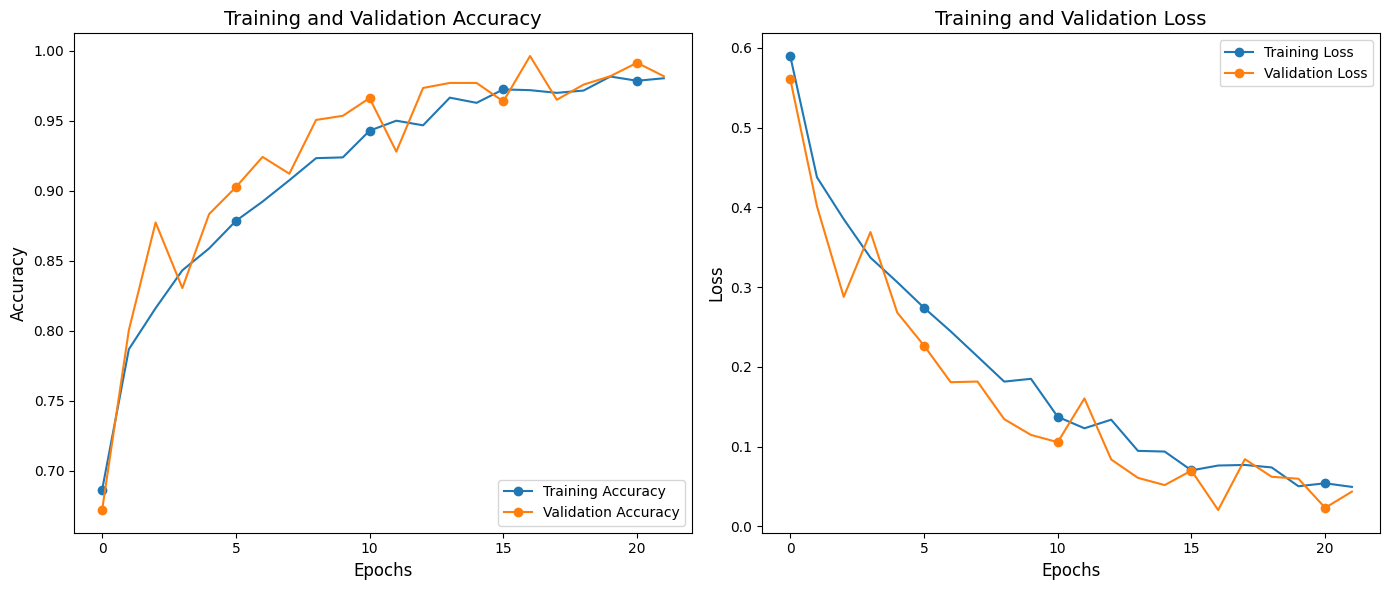

In [30]:
# Get the actual number of epochs run
actual_epochs = len(history.history['loss'])

# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(actual_epochs), history.history['accuracy'], label='Training Accuracy', marker='o', markevery=5, linewidth=1.5)
plt.plot(range(actual_epochs), history.history['val_accuracy'], label='Validation Accuracy', marker='o', markevery=5, linewidth=1.5)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=10)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(actual_epochs), history.history['loss'], label='Training Loss', marker='o', markevery=5, linewidth=1.5)
plt.plot(range(actual_epochs), history.history['val_loss'], label='Validation Loss', marker='o', markevery=5, linewidth=1.5)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [32]:
# Evaluate accuracy on the validation set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.2f}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9899 - loss: 0.0395
Validation Accuracy: 0.99


In [33]:
from sklearn.metrics import classification_report
import numpy as np

# Extract true labels and predictions from the validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())                   # True labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted class indices

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


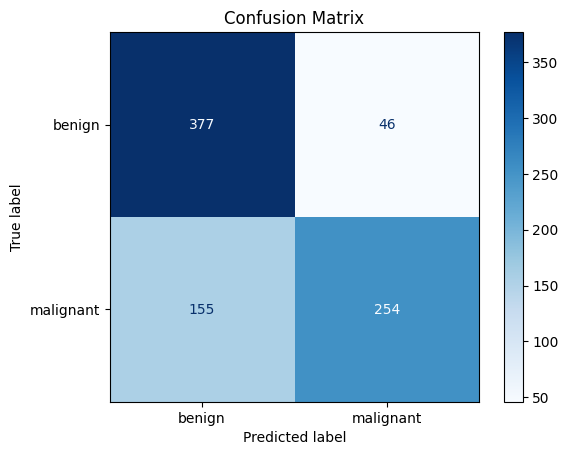

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get the true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model.predict(images), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()


In [34]:
# Evaluate model and print validation metrics
val_metrics = model.evaluate(val_ds, return_dict=True)
print("Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.2f}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9958 - loss: 0.0248
Validation Metrics:
accuracy: 0.99
loss: 0.03


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

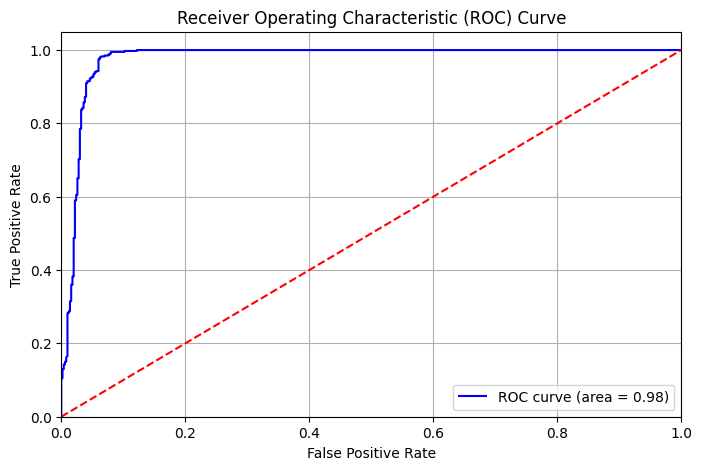

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras import models, layers
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)  # Get predicted probabilities
    y_true.extend(labels.numpy())   # True labels
    y_pred.extend(preds[:, 1])      # Get the probabilities for the positive class

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (chance level)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# RESNET MODEL

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
resnet_model= Sequential()

pretrained_model=tf.keras.applications.ResNet50(include_top=False,
                                               input_shape=(256,256,3),
                                               pooling='avg',
                                               classes=2,
                                               weights='imagenet')
for layer in pretrained_model.layers: 
    layer.trainable = False
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512,activation='relu'))
resnet_model.add(Dense(2,activation='softmax'))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [38]:
resnet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',           
    patience=5,                   
    restore_best_weights=True     
)

In [40]:
from tensorflow.keras.optimizers import Adam

resnet_model.compile(optimizer=Adam(),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=['accuracy'])

In [41]:
EPOCHS=50
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping] 
)

Epoch 1/50


I0000 00:00:1738833025.788646     103 service.cc:145] XLA service 0x571d4aeba180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738833025.788708     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/228 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.4861 - loss: 1.3434 

I0000 00:00:1738833030.043148     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


228/228 ━━━━━━━━━━━━━━━━━━━━ 44s 119ms/step - accuracy: 0.7975 - loss: 0.5504 - val_accuracy: 0.9243 - val_loss: 0.1938
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - accuracy: 0.9049 - loss: 0.2279 - val_accuracy: 0.8939 - val_loss: 0.1980
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.9359 - loss: 0.1583 - val_accuracy: 0.9435 - val_loss: 0.1466
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.9517 - loss: 0.1198 - val_accuracy: 0.9675 - val_loss: 0.0958
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.9527 - loss: 0.1212 - val_accuracy: 0.9796 - val_loss: 0.0739
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.9659 - loss: 0.0844 - val_accuracy: 0.9904 - val_loss: 0.0420
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.9816 - loss: 0.0598 - val_accuracy: 0.9856 - val_loss: 0.0453
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9701 - loss: 0.0770 - val_accura

# RESNET ANALYSIS

In [42]:
scores_resnet=resnet_model.evaluate(test_ds)

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9192 - loss: 0.1912


In [43]:
scores_resnet

[0.19769789278507233, 0.9133333563804626]

In [ ]:
history_resnet.params

In [44]:
history_resnet.history['accuracy']

[0.8488467931747437,
 0.9043108224868774,
 0.9431630969047546,
 0.9526359438896179,
 0.9583333134651184,
 0.9693849682807922,
 0.9772103428840637,
 0.9743272662162781,
 0.9814662337303162,
 0.9794068932533264,
 0.9847862124443054,
 0.9879187345504761,
 0.9877814650535583,
 0.9908017516136169,
 0.9866831302642822,
 0.9785832166671753,
 0.9854475855827332,
 0.9936847686767578]

In [45]:
Resnet_train_acc=history_resnet.history['accuracy']
print("Training Accuracy:", Resnet_train_acc[-1])


Training Accuracy: 0.9936847686767578


In [46]:
Resnet_val_acc= history_resnet.history['val_accuracy']
print("Validation Accuracy:", Resnet_val_acc[-1])

Validation Accuracy: 0.995192289352417


In [47]:
resnet_acc= history_resnet.history['accuracy']
resnet_val_acc= history_resnet.history['val_accuracy']
resnet_loss= history_resnet.history['loss']
resnet_val_loss= history_resnet.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

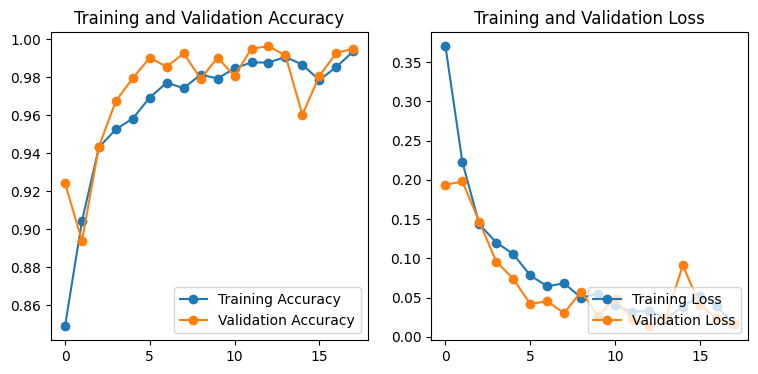

In [48]:
# Get the number of epochs actually run (it will be less than or equal to EPOCHS)
epochs_run = len(history_resnet.history['accuracy'])

# Plot Training and Validation Accuracy
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs_run), history_resnet.history['accuracy'], label='Training Accuracy',marker='o')
plt.plot(range(epochs_run), history_resnet.history['val_accuracy'], label='Validation Accuracy',marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss

plt.subplot(1, 2, 2)
plt.plot(range(epochs_run), history_resnet.history['loss'], label='Training Loss',marker='o')
plt.plot(range(epochs_run), history_resnet.history['val_loss'], label='Validation Loss',marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')


In [49]:
# Evaluate accuracy on the validation set
val_loss, val_accuracy = resnet_model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.2f}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9920 - loss: 0.0279
Validation Accuracy: 0.99


In [50]:
from sklearn.metrics import classification_report
import numpy as np

# Extract true labels and predictions from the validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = resnet_model.predict(images)
    y_true.extend(labels.numpy())                   # True labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted class indices

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
              

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


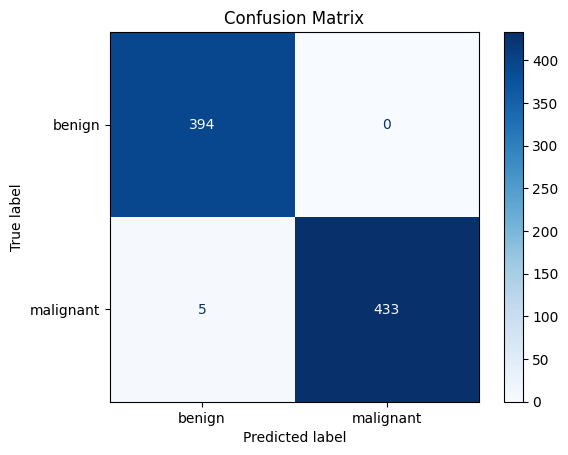

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(resnet_model.predict(images), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')

# Remove the grid
plt.grid(False)

plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

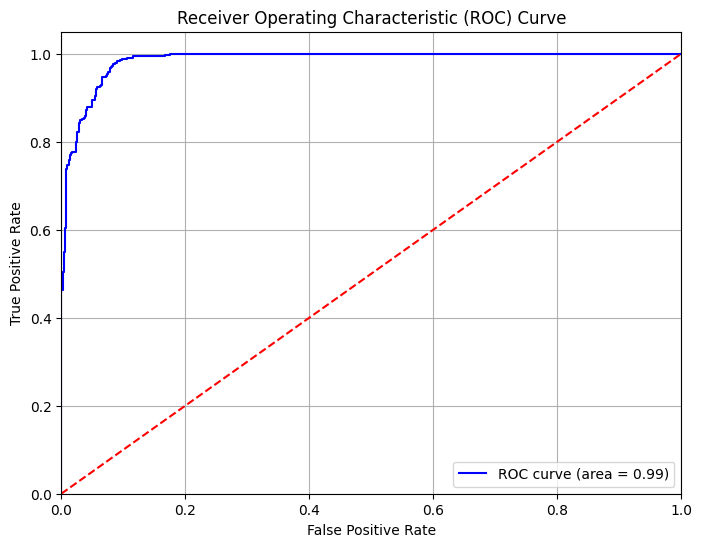

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras import models, layers
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = resnet_model.predict(images)  # Get predicted probabilities
    y_true.extend(labels.numpy())   # True labels
    y_pred.extend(preds[:, 1])      # Get the probabilities for the positive class

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (chance level)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [53]:
# Evaluate model and print validation metrics
val_metrics = resnet_model.evaluate(val_ds, return_dict=True)
print("Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.2f}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9907 - loss: 0.0324
Validation Metrics:
accuracy: 0.99
loss: 0.03


# EFFICIENT NET MODEL

In [54]:
!pip install efficientnet


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


In [55]:
from tensorflow.keras.applications import EfficientNetB0
import efficientnet.tfkeras as efn

base_model = efn.EfficientNetB0(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')


16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [56]:
for layer in base_model.layers:
    layer.trainable = False

In [57]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
predictions = Dense(1, activation="sigmoid")(x)
model_efficientNet = Model(inputs=base_model.input, outputs=predictions)

In [58]:
from tensorflow.keras.optimizers import RMSprop
model_efficientNet.compile(optimizer=RMSprop(learning_rate=0.0001, decay=1e-6), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [59]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',          
    patience=5,                  
    restore_best_weights=True     
)

In [60]:
history_efficientNet = model_efficientNet.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=100,
    epochs=EPOCHS,
    callbacks=[early_stopping] 
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 226ms/step - accuracy: 0.5517 - loss: 257.4208 - val_accuracy: 0.5240 - val_loss: 20.6703
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.5645 - loss: 24.0653 - val_accuracy: 0.5709 - val_loss: 1.4262
Epoch 3/50
 27/100 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5454 - loss: 3.3679

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.5546 - loss: 3.2582 - val_accuracy: 0.6094 - val_loss: 1.3928
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.5665 - loss: 1.9339 - val_accuracy: 0.6178 - val_loss: 0.9187
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 288ms/step - accuracy: 0.5722 - loss: 1.3696 - val_accuracy: 0.5913 - val_loss: 0.9203
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.5766 - loss: 1.3108 - val_accuracy: 0.6298 - val_loss: 0.7382
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.5616 - loss: 1.1332 - val_accuracy: 0.6238 - val_loss: 1.0413
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.5841 - loss: 1.0551 - val_accuracy: 0.6779 - val_loss: 0.6574
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.6101 - loss: 0.7801 - val_accuracy: 0.6562 - val_loss: 0.7201
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.6222 - loss: 0.8711 - val_acc

# EFFICIENT NET ANALYSIS

In [61]:
scores_efficientNet=model_efficientNet.evaluate(test_ds)

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.6962 - loss: 0.6535


In [62]:
scores_efficientNet

[0.6352998614311218, 0.6899999976158142]

In [63]:
history_efficientNet.params

{'verbose': 'auto', 'epochs': 50, 'steps': 100}

In [64]:
history_efficientNet.history['accuracy']

[0.5693749785423279,
 0.5809375047683716,
 0.5580357313156128,
 0.5665624737739563,
 0.5671267509460449,
 0.5736607313156128,
 0.5703125,
 0.586888313293457,
 0.6037946343421936,
 0.6184375286102295,
 0.596612274646759,
 0.5959821343421936,
 0.6234375238418579,
 0.6282935738563538,
 0.6283482313156128,
 0.6221874952316284,
 0.6225000023841858]

In [65]:
Eff_train_acc = history_efficientNet.history['accuracy']
print("Training Accuracy:", Eff_train_acc[-1])

Training Accuracy: 0.6225000023841858


In [66]:
Eff_val_acc = history_efficientNet.history['val_accuracy']
print("Validation Accuracy:", Eff_val_acc[-1])

Validation Accuracy: 0.6814903616905212


In [67]:
efficientNet_acc= history_efficientNet.history['accuracy']
efficientNet_val_acc= history_efficientNet.history['val_accuracy']
efficientNet_loss= history_efficientNet.history['loss']
efficientNet_val_loss= history_efficientNet.history['val_loss']

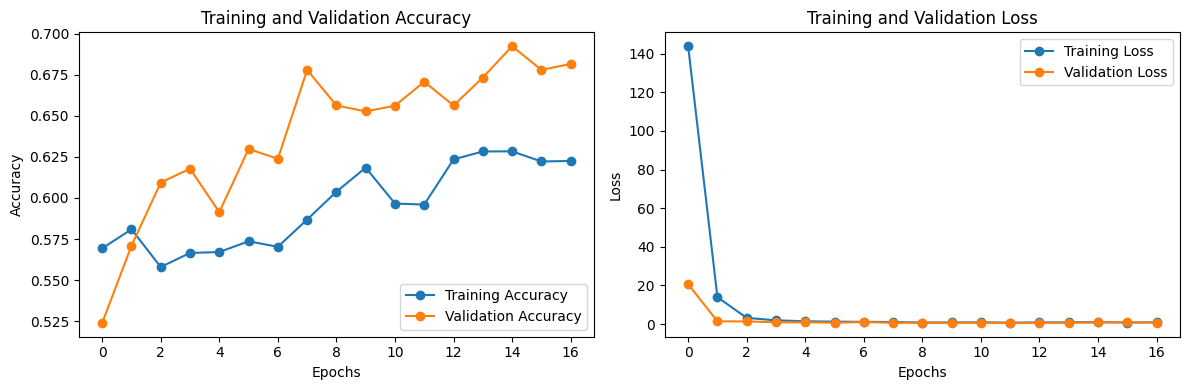

In [68]:
# Determine the number of epochs actually run
epochs_run = len(efficientNet_acc)

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs_run), efficientNet_acc, label='Training Accuracy', marker='o')
plt.plot(range(epochs_run), efficientNet_val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs_run), efficientNet_loss, label='Training Loss', marker='o')
plt.plot(range(epochs_run), efficientNet_val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [69]:
# Evaluate accuracy on the validation set
val_loss, val_accuracy = model_efficientNet.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.2f}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.6635 - loss: 0.6486
Validation Accuracy: 0.67


In [70]:
from sklearn.metrics import classification_report
import numpy as np

# Extract true labels and predictions from the validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model_efficientNet.predict(images)
    y_true.extend(labels.numpy())                   # True labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted class indices

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
              

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


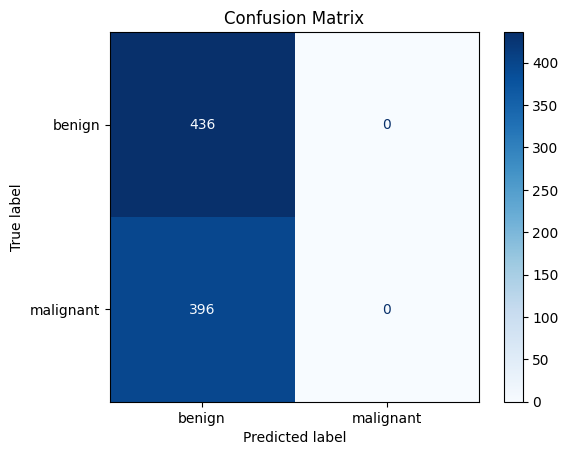

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model_efficientNet.predict(images), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')

# Remove the grid
plt.grid(False)

plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

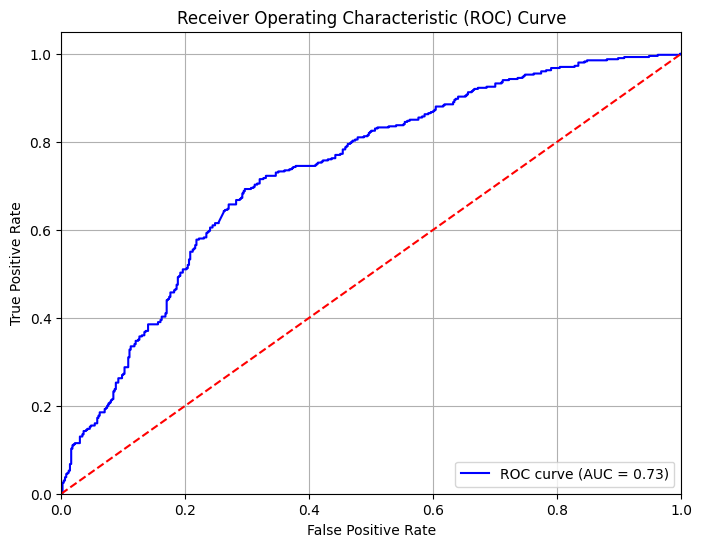

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, test_ds):
    y_true = []
    y_pred = []
    
    # Get predictions and true labels
    for images, labels in test_ds:
        preds = model_efficientNet.predict(images)         # Model predictions
        y_true.extend(labels.numpy())         # True labels
        y_pred.extend(preds.flatten())        # Flatten predictions for positive class
    
    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (chance level)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Usage Example:
# Assuming `model` is your trained model and `test_ds` is your test dataset
plot_roc_curve(model, test_ds)


In [73]:
# Evaluate model and print validation metrics
val_metrics = model_efficientNet.evaluate(val_ds, return_dict=True)
print("Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.2f}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.6563 - loss: 0.6440
Validation Metrics:
accuracy: 0.66
loss: 0.63


# COMPARATIVE STUDY

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9348 - loss: 0.2235
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9247 - loss: 0.1715
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6910 - loss: 0.6316


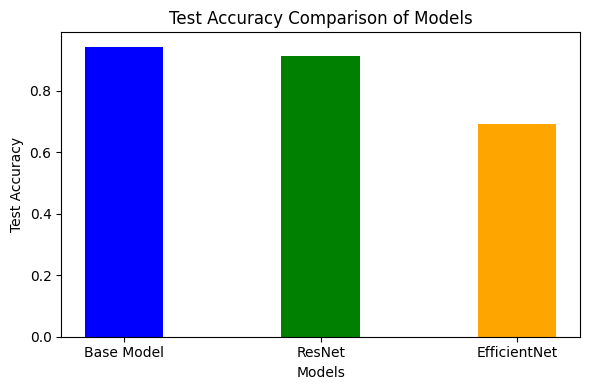

In [74]:
import matplotlib.pyplot as plt

# Evaluate models and extract accuracy
scores = model.evaluate(test_ds)
scores_resnet = resnet_model.evaluate(test_ds)
scores_efficientNet = model_efficientNet.evaluate(test_ds)

# Assuming the accuracy is the second value in the `scores` array
accuracy_model = scores[1]
accuracy_resnet = scores_resnet[1]
accuracy_efficientNet = scores_efficientNet[1]

# Create a list of model names and corresponding accuracies
model_names = ['Base Model', 'ResNet', 'EfficientNet']
accuracies = [accuracy_model, accuracy_resnet, accuracy_efficientNet]

# Plotting the accuracies on a bar graph
plt.figure(figsize=(6, 4))  # Decreased figure size
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange'], width=0.4)  # Reduced bar width

# Adding titles and labels
plt.title('Test Accuracy Comparison of Models', fontsize=12)
plt.xlabel('Models', fontsize=10)
plt.ylabel('Test Accuracy', fontsize=10)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


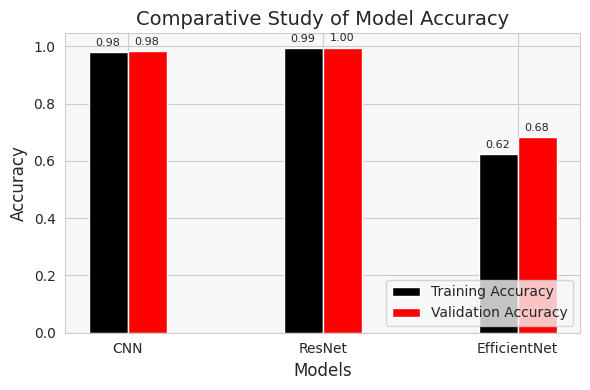

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Example accuracy and validation accuracy for the models
# Replace these with your actual values
models = ['CNN', 'ResNet', 'EfficientNet']
# Assuming CNN_train_acc, Resnet_train_acc, Eff_train_acc are lists with accuracy per epoch
# Use the last value (or final accuracy) for each model
accuracy = [CNN_train_acc[-1], Resnet_train_acc[-1], Eff_train_acc[-1]]  # Final Training accuracy for CNN, ResNet, and EfficientNet
val_accuracy = [CNN_val_acc[-1], Resnet_val_acc[-1], Eff_val_acc[-1]]  # Final Validation accuracy for CNN, ResNet, and EfficientNet

# Set Seaborn style and customize the background
sns.set_style("whitegrid")
plt.rcParams['axes.facecolor'] = '#f7f7f7'  # Off-white background color

# Setting up the bar positions
x = np.arange(len(models))  # the label locations
width = 0.2  # Smaller bar width

# Create the bar chart
fig, ax = plt.subplots(figsize=(6, 4))  # Smaller figure size
bars1 = ax.bar(x - width/2, accuracy, width, label='Training Accuracy', color='black')
bars2 = ax.bar(x + width/2, val_accuracy, width, label='Validation Accuracy', color='red')

# Add labels, title, and legend
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Comparative Study of Model Accuracy', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=10)
ax.legend(fontsize=10, loc='lower right')

# Annotate bars with values
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3),  # Offset by 3 points
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height), 
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


# IMAGE PREDICTION AND PERCENTAGE CALCULATION

In [80]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2

# Assuming your model is already trained and compiled
# If not, you can load a saved model using tf.keras.models.load_model('your_model_path')

# Function to preprocess the image
def get_img_array(img_path, size):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=size)
    # Convert the image to a numpy array
    array = image.img_to_array(img)
    # Expand dimensions to create a batch of size 1
    array = np.expand_dims(array, axis=0)
    return array

# Path to the image you want to visualize
img_path = '/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/val/malignant/malignant (1)-rotated1-rotated1-rotated1.png'  # Replace with your image path

# Prepare the image
img_array = get_img_array(img_path, size=(img_size, img_size))

In [81]:
# Predict the class of the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
class_names = ['benign', 'malignant']  # Ensure these match your dataset's class names
predicted_label = class_names[predicted_class]

print(f"The model predicts this image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The model predicts this image is: malignant


**GRAD CAM**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
Gradients shape: (1, 14, 14, 512)
Pooled gradients shape: (512,)
Activations shape: (14, 14, 512)


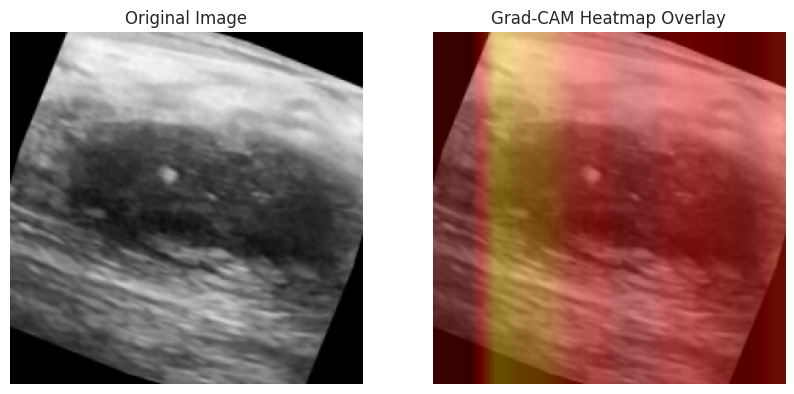

Affected Percentage: 6.12%


In [90]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image

# Function to preprocess image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)  # Preprocess for VGG16
    return img_array, img

# Function to get Grad-CAM heatmap
def get_grad_cam(model, img_array, layer_name):
    # Get model predictions
    preds = model.predict(img_array)
    class_idx = np.argmax(preds[0])  # Get the class index for which we want to generate Grad-CAM
    
    # Create a model that maps the input to the activations of the chosen layer and the predictions
    grad_model = tf.keras.models.Model(
        inputs=model.input,  # Use model input
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    # Convert img_array to a tensor if not already
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Calculate gradients
    with tf.GradientTape() as tape:
        # Watch the input image tensor
        tape.watch(img_tensor)
        activations, predictions = grad_model(img_tensor)
        loss = predictions[:, class_idx]
    
    # Compute the gradients of the loss with respect to the chosen layer's activations
    grads = tape.gradient(loss, activations)
    
    # Check if grads is None (i.e., gradients are not being calculated)
    if grads is None:
        raise ValueError("Gradients are not being computed. Check if the target layer is correct.")
    
    # Ensure grads is not empty and check the shapes
    print(f"Gradients shape: {grads.shape}")
        
    # Pool gradients using global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling
    print(f"Pooled gradients shape: {pooled_grads.shape}")
        
    activations = activations[0]
    print(f"Activations shape: {activations.shape}")
        
    # Check the shape of pooled_grads before reshaping
    if pooled_grads.shape != (activations.shape[-1],):
        raise ValueError(f"Pooled gradients shape does not match activation channels: {pooled_grads.shape}")
        
    # Reshape pooled gradients to match activations shape for broadcasting
    pooled_grads = tf.reshape(pooled_grads, (1, 1, 1, activations.shape[-1]))
        
    # Multiply each channel in the feature map by the pooled gradients
    activations *= pooled_grads
        
    # Create the heatmap by taking the mean of the activations along the channel axis
    heatmap = np.mean(activations, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # Normalize to [0, 1]
    
    return heatmap

# Function to overlay the heatmap on the original image
# Function to overlay the heatmap on the original image
# Function to overlay the heatmap on the original image
def overlay_heatmap_on_image(original_img, heatmap, alpha=0.4):
    """
    Overlay the heatmap on top of the original image
    """
    # Convert original_img from PIL to NumPy array
    original_img = np.array(original_img)
    
    # Resize heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

    # Ensure heatmap is 2D (single channel)
    if len(heatmap_resized.shape) != 2:
        heatmap_resized = np.mean(heatmap_resized, axis=-1)  # Take the mean if it has multiple channels

    # Normalize the heatmap to [0, 255] and convert to uint8
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Apply the heatmap as a colormap (jet color map)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Ensure the original image is 3 channels (RGB)
    if len(original_img.shape) == 2:  # If it's grayscale
        original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)

    # Overlay the heatmap on the image
    overlayed_img = cv2.addWeighted(heatmap_colored, alpha, original_img, 1 - alpha, 0)
    
    return overlayed_img



# Function to calculate the percentage of affected tissue in the heatmap
def calculate_affected_percentage(heatmap, threshold=0.5):
    """
    Calculate the percentage of affected tissue based on a threshold for the heatmap intensity
    """
    # Apply the threshold to the heatmap
    affected_area = np.sum(heatmap > threshold)
    
    # Calculate the total area
    total_area = heatmap.size
    
    # Calculate the percentage of affected area
    affected_percentage = (affected_area / total_area) * 100
    
    return affected_percentage

# Main code to generate and overlay Grad-CAM heatmap
img_path = '/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/val/malignant/malignant (1)-rotated1-rotated1-rotated32.png'  # Replace with your image path
layer_name = 'block5_conv3'  # Replace with your desired layer name

# Load and preprocess the image
img_array, img = preprocess_image(img_path)

# Load the pre-trained model (e.g., VGG16)
model = tf.keras.applications.VGG16(weights='imagenet')

# Get Grad-CAM heatmap for the chosen layer
heatmap = get_grad_cam(model, img_array, layer_name)

# Overlay the heatmap on the image
overlayed_img = overlay_heatmap_on_image(img, heatmap)

# Display the results
plt.figure(figsize=(10, 10))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Image with overlayed heatmap
plt.subplot(1, 2, 2)
plt.imshow(overlayed_img)
plt.title('Grad-CAM Heatmap Overlay')
plt.axis('off')

plt.show()

# Calculate the affected percentage in the heatmap
affected_percentage = calculate_affected_percentage(heatmap)
print(f"Affected Percentage: {affected_percentage:.2f}%")


**INTEGRATED GRADIENT**

In [86]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
# Function to calculate Integrated Gradients
def integrated_gradients(model, img_array, baseline=None, num_steps=50):
    if baseline is None:
        baseline = np.zeros_like(img_array)  # Default baseline is an image of all zeros
    
    # Convert to TensorFlow tensors
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
    
    # Create linear interpolation between baseline and image
    alphas = np.linspace(0, 1, num=num_steps)
    grads = np.zeros_like(img_array)
    
    for alpha in alphas:
        interpolated_image = baseline + alpha * (img_array - baseline)
        with tf.GradientTape() as tape:
            tape.watch(interpolated_image)
            prediction = model(interpolated_image, training=False)
        
        grads += tape.gradient(prediction, interpolated_image)
    
    # Calculate the integrated gradients
    integrated_grads = (img_array - baseline) * grads / num_steps
    return integrated_grads

In [87]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)  # Resize to target size (224, 224)
    img = img.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
    
    # Add batch dimension
    img = np.expand_dims(img, axis=0)  # Add batch dimension (1, 224, 224, 3)
    
    return img  # Return image with batch dimension

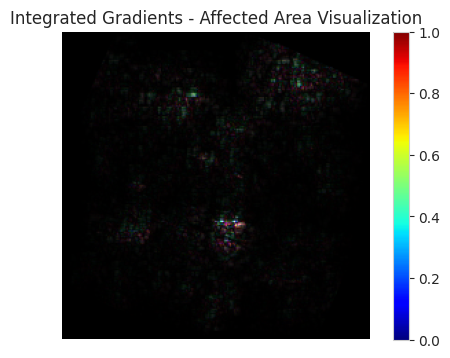

Percentage of affected cancer tissue: 1.98%


In [88]:
# Visualizing the integrated gradients and the affected area
def visualize_integrated_gradients(model, image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    
    # Get the integrated gradients for the image
    integrated_grads = integrated_gradients(model, img_array)
    
    # Normalize the integrated gradients to [0, 1] range
    integrated_grads = np.abs(integrated_grads)  # Take the absolute value of gradients
    integrated_grads = (integrated_grads - np.min(integrated_grads)) / (np.max(integrated_grads) - np.min(integrated_grads))

    # Visualize the integrated gradients
    plt.figure(figsize=(6, 4))
    plt.imshow(integrated_grads[0], cmap='jet')  # Remove the batch dimension for visualization
    plt.colorbar()
    plt.title("Integrated Gradients - Affected Area Visualization")
    plt.grid(False)  # Remove the grid
    plt.axis("off")  # Optional: Remove axis for a cleaner view
    plt.show()

    # Calculate the percentage of affected tissue
    threshold = 0.1  # You can adjust this threshold based on your needs
    affected_area = np.sum(integrated_grads[0] > threshold) / integrated_grads[0].size
    print(f"Percentage of affected cancer tissue: {affected_area * 100:.2f}%")

# Example usage of visualization and percentage calculation
image_path = '/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/val/malignant/malignant (1)-rotated1-sharpened-rotated32.png'  # Replace with your image path
visualize_integrated_gradients(model, image_path)
